In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_10_mixup_ls")' FastaiNotebook_10_mixup_ls

Installing packages:
	.package(path: "/home/ubuntu/git/fastai_docs/dev_swift/FastaiNotebook_10_mixup_ls")
		FastaiNotebook_10_mixup_ls
With SwiftPM flags: []
Working in: /tmp/tmp6v9yqn33/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
// export
import Path
import TensorFlow

In [ ]:
import FastaiNotebook_10_mixup_ls

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Load data

Let's load the data using the functions designed in 08. The first one is a helper function to download the dataset and returns the path where it's decompressed.

In [ ]:
let path = downloadImagette()

Then we can use the data block API in swift: first we grab recursively all the jpeg files in `path`.

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["jpeg", "jpg"])

Then we split them according to the grandparent folder. `train` for the training set (which is the default) and `val` for the validation set.

In [ ]:
let sd = SplitData(il, fromFunc: {grandParentSplitter(fName: $0, valid: "val")})

We define our processors for the training set and the validation set. The difference with python is that we have to specify a noop processor (with a type) when we don't want to do anything.

In [ ]:
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())

Then we can label our data using the parent directory and those two processors.

In [ ]:
let sld = SplitLabeledData(sd, fromFunc: parentLabeler, procItem: &procItem, procLabel: &procLabel)

We can then convert to a databunch by specifying two function that will convert our items and our labels to `Tensor`. For the items we use `pathsToTensor` that converts the `Path` object to their string representation then `StringTensor`. For the labels,  the function `intsToTensor` just convert the indices we have in proper tensors.

In [ ]:
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor, bs: 64)

The main difference with python is that the transforms are all applied directly on the datasets by `tf.data`. Even opening on the image is such a transform, that will take a `StringTensor` and return a tensor of `UInt8`. We have written a function that opens the image in a filename and returns it decoded and resized to `size`, which is the transform we apply to our items.

In [ ]:
let data = transformData(rawData, tfmItem: { openAndResize(fname: $0, size: 128) })

We can then have a look by grabbing one batch.

In [ ]:
let batch = data.train.oneBatch()!

Our batches have two attributes `xb` and `yb` that contain the inputs and targets respectively.

In [ ]:
print(batch.xb.shape)
print(batch.yb.shape)

TensorShape(dimensions: [64, 128, 128, 3])
TensorShape(dimensions: [64])


If we decode the labels suing our processor, we can plot images with their corresponding classes:

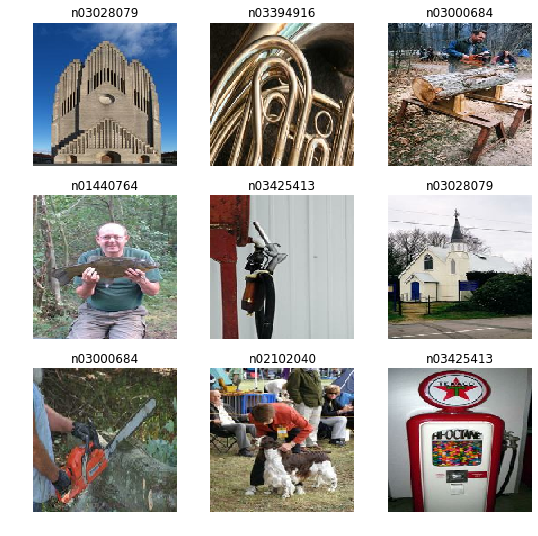

In [ ]:
let labels = batch.yb.scalars.map { procLabel.vocab![Int($0)] }
showImages(batch.xb, labels: labels)

## XResnet

We build the same xresnet we had in fastai over PyTorch. Modules in S4TF are `struct` that conform to the `Layer` protocol. You define any layer it uses as attributes that you have to properly set in the `init` function. The equivalent of `forward` in PyTorch is `call`.

We are using our custom fastai layers that have the prefix `FA` because they contain experimental features that might eventually be merged in S4TF. There is a NoBiasConv layer separate from the Conv Layer because S4TF doesn't yet support control flow. That means you can't have if statements or for loops in the `call` function.

In [ ]:
public struct ConvLayer: Layer {
    public var bn: FABatchNorm<Float>
    public var conv: FANoBiasConv2D<Float>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1, zeroBn: Bool = false, act: Bool = true){
        bn = FABatchNorm(featureCount: cOut)
        conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: act ? relu : identity)
        if zeroBn { bn.scale = Tensor(zeros: [cOut]) }
    }
    
    @differentiable
    public func call(_ input: TF) -> TF {
        return bn(conv(input))
    }
}

However we will need some optional layers to have refactored resnet implementation: in the shortcuts, we sometimes apply an average pool or a convolution layer, but most of the time we don't do anything. To be able to have that in S4TF, we write a customized protocol called `SwitchableLayer`. It inherits from `Layer` and adds a boolean `isOn` and a differentiable `forward` function. A structure conforming to it will return the result of `forward` if `isOn` is `true`, otherwise it won't do anything.

As we said before, if statements aren't differentiable (yet) but we can create a custom function that will manually compute the gradients of our switchable layer.

In [ ]:
//A layer that you can switch off to do the identity instead
public protocol SwitchableLayer: Layer {
    associatedtype Input
    var isOn: Bool {get set}
    
    @differentiable func forward(_ input: Input) -> Input
}

public extension SwitchableLayer {
    func call(_ input: Input) -> Input {
        return isOn ? forward(input) : input
    }

    @differentiating(call)
    func gradForward(_ input: Input) ->
        (value: Input, pullback: (Self.Input.CotangentVector) ->
            (Self.CotangentVector, Self.Input.CotangentVector)) {
        if isOn { return valueWithPullback(at: input) { $0.forward($1) } }
        else { return (input, {v in return (Self.CotangentVector.zero, v)}) }
    }
}

Then we use this protocol to create a `MaybeAvgPool2D` layer and a `MaybeConv` layer. The little downside is that we will have to create a fake convolution for the `MaybeConv` that are just identity, but we will just create a 1x1x1x1 weight matrix so that it doesn't take much memory.

In [ ]:
public struct MaybeAvgPool2D: SwitchableLayer {
    var pool: FAAvgPool2D<Float>
    @noDerivative public var isOn = false
    
    @differentiable public func forward(_ input: TF) -> TF { return pool(input) }
    
    public init(_ sz: Int) {
        isOn = (sz > 1)
        pool = FAAvgPool2D<Float>(sz)
    }
}

In [ ]:
public struct MaybeConv: SwitchableLayer {
    var conv: ConvLayer
    @noDerivative public var isOn = false
    
    @differentiable public func forward(_ input: TF) -> TF { return conv(input) }
    
    public init(_ cIn: Int, _ cOut: Int) {
        isOn = (cIn > 1) || (cOut > 1)
        conv = ConvLayer(cIn, cOut, ks: 1, act: false)
    }
}

With those two maybe layers, we can write a `ResBlock` as we are used to. We can have array of layers that have the same type, and such an array can be treated as if it was a normal layer.

In [ ]:
public struct ResBlock: Layer {
    public var convs: [ConvLayer]
    public var idConv: MaybeConv
    public var pool: MaybeAvgPool2D
    
    public init(_ expansion: Int, _ ni: Int, _ nh: Int, stride: Int = 1){
        let (nf, nin) = (nh*expansion,ni*expansion)
        convs = [ConvLayer(nin, nh, ks: 1)]
        convs += (expansion==1) ? [
            ConvLayer(nh, nf, ks: 3, stride: stride, zeroBn: true, act: false)
        ] : [
            ConvLayer(nh, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 1, zeroBn: true, act: false)
        ]
        idConv = nin==nf ? MaybeConv(1,1) : MaybeConv(nin, nf)
        pool = MaybeAvgPool2D(stride)
    }
    
    @differentiable
    public func call(_ inp: TF) -> TF {
        return relu(convs(inp) + idConv(pool(inp)))
    }
    
}

Then we can create our `XResnet` pretty much the same way as in pytorch. The list comprehesions are replaced by uses of `map` or `reduce`. The `makeLayer` function is out side of the `XResNet` structure because it can't be used in the `init` otherwise (in swift, you can only use self in the init when all the attributes have been properly set, and this `makeLayer` function is used to create the attribute `blocks`).

In [ ]:
func makeLayer(_ expansion: Int, _ ni: Int, _ nf: Int, _ nBlocks: Int, stride: Int) -> [ResBlock] {
    return (0..<nBlocks).map { ResBlock(expansion, $0==0 ? ni : nf, nf, stride: $0==0 ? stride : 1) }
}

In [ ]:
public struct XResNet: Layer {
    public var stem: [ConvLayer]
    public var maxPool = MaxPool2D<Float>(poolSize: (3,3), strides: (2,2), padding: .same)
    public var blocks: [ResBlock]
    public var pool = GlobalAvgPool2D<Float>()
    public var linear: Dense<Float>
    
    public init(_ expansion: Int, _ layers: [Int], cIn: Int = 3, cOut: Int = 1000){
        var nfs = [cIn, (cIn+1)*8, 64, 64]
        stem = (0..<3).map{ ConvLayer(nfs[$0], nfs[$0+1], stride: $0==0 ? 2 : 1)}
        nfs = [64/expansion,64,128,256,512]
        blocks = Array(layers.enumerated()).map { (i,l) in 
            return makeLayer(expansion, nfs[i], nfs[i+1], l, stride: i==0 ? 1 : 2)
        }.reduce([], +)
        linear = Dense(inputSize: nfs.last!*expansion, outputSize: cOut)
    }
    
    @differentiable
    public func call(_ inp: TF) -> TF {
        return linear(pool(blocks(maxPool(stem(inp)))))
    }
    
}

In [ ]:
func xresnet18 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [2, 2, 2, 2], cIn: cIn, cOut: cOut) }
func xresnet34 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
func xresnet50 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
func xresnet101(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 23, 3], cIn: cIn, cOut: cOut) }
func xresnet152(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 8, 36, 3], cIn: cIn, cOut: cOut) }

To define a `Learner` we need our data, a model initializer function, and optimizer initializer function and a loss function. The model initilializer is a simple closure that returns the model.

In [ ]:
func modelInit() -> XResNet { return xresnet18(cOut: 10) }

The optimizer function is a convenience function we wrote in notebook 09 (like we had done in the python version) that returns a `StatefulOptimizer` with all the necessary stats/step delegates.

In [ ]:
let optFunc: (XResNet) -> StatefulOptimizer<XResNet> = AdamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)

Then we can create our `Learner`. The loss function is the classic cross entropy + softmax, and is given by S4TF.

In [ ]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)

In swift, callbacks are called delegates. We have written a convenience function to automatically add the basic ones we need (train/eval, the recorder, metrics progress bar). This function returns the `recorder` if we want to look at losses or do some plots later.

Then we add the delegate to normalize our inputs with the statistics of ImageNet.

In [ ]:
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegate(learner.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))

Then we can fit with the 1cycle policy:

In [ ]:
learner.addOneCycleDelegates(1e-3, pctStart: 0.5)
learner.fit(5)

Epoch 0: [1.334705, 0.586]                                                      
Epoch 1: [1.5237166, 0.572]                                                     
Epoch 2: [0.98670506, 0.716]                                                    
Epoch 3: [0.6667311, 0.804]                                                     
Epoch 4: [0.5287461, 0.854]                                                     


In [ ]:
learner.addOneCycleDelegates(1e-3, pctStart: 0.5)
learner.fit(1)

Epoch 0: [1.1497202, 0.636]                                                     
